# Model Exercise 


## This note book consist of two parts
1. Building Model 
2.Scoring the New Data 


### 1. Building Model

###### Importing Libraries

In [1]:
import pandas as pd
import datetime as dt
import pandasql
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

###### Loading Data 

In [2]:
df_init=pd.read_csv("C:/Users/shukl/Desktop/Epsilon/Data.csv")


###### Cleaning and Preparing Data 

In [3]:
df_init.columns = df_init.columns.str.replace(' ', '')
df_init.InvoiceDate=pd.to_datetime(df_init.InvoiceDate)
df_init = pandasql.sqldf("SELECT *,Quantity*Price as Total_Spent FROM df_init where Quantity>0 and Price>0;", globals())
df_init['InvoiceDate'] = pd.to_datetime(df_init['InvoiceDate']).dt.normalize()
df_init['InvoiceDate'] = pd.to_datetime(df_init['InvoiceDate']).dt.date

start_date_model_cust = pd.to_datetime('10/9/2011 0:00', utc= True)
end_date_model_cust = pd.to_datetime('11/9/2011 23:59', utc= True)
model_cust=df_init[(df_init['InvoiceDate'] > start_date_model_cust) & (df_init['InvoiceDate'] < end_date_model_cust)]
model_cust['Retain'] = 1
model_cust = model_cust[['CustomerID','Retain']]
model_cust=model_cust.drop_duplicates()

start_date_model_main = pd.to_datetime('1/12/2009 0:00', utc= True)
end_date_model_main = pd.to_datetime('9/30/2011 23:59', utc= True)
model_main=df_init[(df_init['InvoiceDate'] > start_date_model_main) & (df_init['InvoiceDate'] < end_date_model_main)]

start_date_model_extra = pd.to_datetime('10/1/2011 0:00', utc= True)
end_date_model_extra = pd.to_datetime('10/9/2011 23:59', utc= True)
model_extra=df_init[(df_init['InvoiceDate'] > start_date_model_extra) & (df_init['InvoiceDate'] < end_date_model_extra)]

model_main['InvoiceDate'] = pd.to_datetime(model_main['InvoiceDate'], errors='coerce')
model_main['InvoiceDate'] = model_main['InvoiceDate'].dt.strftime('%m/%Y')
model_extra['InvoiceDate'] = pd.to_datetime(model_extra['InvoiceDate'], errors='coerce')
model_extra['InvoiceDate'] = model_extra['InvoiceDate'].dt.strftime('%m/%Y')

model_main=pandasql.sqldf("SELECT CustomerID, count(Invoice) as Visits, InvoiceDate,sum(Quantity) as Total_Quantity,sum(Total_Spent) as Grand_Spent FROM model_main Group by CustomerID,InvoiceDate;", globals())
model_main=model_main.dropna()
model_extra=pandasql.sqldf("SELECT CustomerID, count(Invoice) as Visits, sum(Quantity) as Total_Quantity,sum(Total_Spent) as Grand_Spent FROM model_extra Group by CustomerID;", globals())
model_extra=model_extra.dropna()

model_main_1=pd.pivot_table(model_main, index='CustomerID', columns='InvoiceDate', values='Visits')
model_main_2=pd.pivot_table(model_main, index='CustomerID', columns='InvoiceDate', values='Total_Quantity')
model_main_3=pd.pivot_table(model_main, index='CustomerID', columns='InvoiceDate', values='Grand_Spent')
model_main_1=model_main_1.fillna(0)
model_main_2=model_main_2.fillna(0)
model_main_3=model_main_3.fillna(0)
model_main_1.rename(columns={'12/2009':'M_1','01/2010':'M_2','02/2010':'M_3','03/2010':'M_4','04/2010':'M_5','05/2010':'M_6','06/2010':'M_7','07/2010':'M_8','08/2010':'M_9','09/2010':'M_10','10/2010':'M_11','11/2010':'M_12','12/2010':'M_13','01/2011':'M_14','02/2011':'M_15','03/2011':'M_16','04/2011':'M_17','05/2011':'M_18','06/2011':'M_19','07/2011':'M_20','08/2011':'M_21','09/2011':'M_22'},inplace=True)
model_main_2.rename(columns={'12/2009':'M_1','01/2010':'M_2','02/2010':'M_3','03/2010':'M_4','04/2010':'M_5','05/2010':'M_6','06/2010':'M_7','07/2010':'M_8','08/2010':'M_9','09/2010':'M_10','10/2010':'M_11','11/2010':'M_12','12/2010':'M_13','01/2011':'M_14','02/2011':'M_15','03/2011':'M_16','04/2011':'M_17','05/2011':'M_18','06/2011':'M_19','07/2011':'M_20','08/2011':'M_21','09/2011':'M_22'},inplace=True)
model_main_3.rename(columns={'12/2009':'M_1','01/2010':'M_2','02/2010':'M_3','03/2010':'M_4','04/2010':'M_5','05/2010':'M_6','06/2010':'M_7','07/2010':'M_8','08/2010':'M_9','09/2010':'M_10','10/2010':'M_11','11/2010':'M_12','12/2010':'M_13','01/2011':'M_14','02/2011':'M_15','03/2011':'M_16','04/2011':'M_17','05/2011':'M_18','06/2011':'M_19','07/2011':'M_20','08/2011':'M_21','09/2011':'M_22'},inplace=True)

model_main_1=model_main_1.add_prefix('Visits_')
model_main_2=model_main_2.add_prefix('Total_Quantity_')
model_main_3=model_main_3.add_prefix('Grand_Spent_')
model_extra=model_extra.add_prefix('model_extra_')

model_main = pandasql.sqldf("SELECT * FROM model_main_1 LEFT JOIN model_main_2 ON model_main_1.CustomerID = model_main_2.CustomerID;", globals())
model_main=pandasql.sqldf("SELECT * FROM model_main LEFT JOIN model_main_3 ON model_main.CustomerID = model_main_3.CustomerID;", globals())
model_main=pandasql.sqldf("SELECT * FROM model_main LEFT JOIN model_extra ON model_main.CustomerID = model_extra.model_extra_CustomerID;", globals())
model_main=pandasql.sqldf("SELECT * FROM model_main LEFT JOIN model_cust ON model_main.CustomerID = model_cust.CustomerID;", globals())
model_main=model_main.loc[:,~model_main.columns.duplicated()]
model_main = model_main.drop('model_extra_CustomerID', 1)
model_main=model_main.fillna(0)

<ipython-input-3-a3ab3b372c21>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_cust['Retain'] = 1
<ipython-input-3-a3ab3b372c21>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_main['InvoiceDate'] = pd.to_datetime(model_main['InvoiceDate'], errors='coerce')
<ipython-input-3-a3ab3b372c21>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

###### Partitioning Data

In [4]:
array = model_main.values
X = array[:,1:69]
y = array[:,70]
X=np.asarray(X)
y=np.asarray(y)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=47)

###### Building Models and Applying Algorithms

In [5]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto',probability=True)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

LR: 0.756458 (0.020267)
LDA: 0.787520 (0.007654)
KNN: 0.779224 (0.015991)
CART: 0.731812 (0.021555)
NB: 0.782685 (0.013990)
SVM: 0.773941 (0.001729)


###### Comparing Algorithms

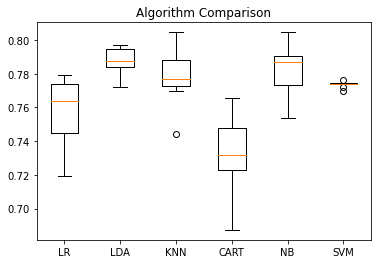

In [6]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()


###### Calcualting Confusion Matrics

In [7]:
modelLR=LogisticRegression(multi_class='ovr', solver='liblinear')
modelLDA=LinearDiscriminantAnalysis()
modelKNN=KNeighborsClassifier()
modelCART=DecisionTreeClassifier()
modelNB=GaussianNB()
modelSVM=SVC(gamma='auto',probability=True)

modelLR.fit(X_train, Y_train)
modelLDA.fit(X_train, Y_train)
modelKNN.fit(X_train, Y_train)
modelCART.fit(X_train, Y_train)
modelNB.fit(X_train, Y_train)
modelSVM.fit(X_train, Y_train)

predictionsLR = modelLR.predict(X_train)
predictionsLDA = modelLDA.predict(X_train)
predictionsKNN = modelKNN.predict(X_train)
predictionsCART = modelCART.predict(X_train)
predictionsNB = modelNB.predict(X_train)
predictionsSVM = modelSVM.predict(X_train)

pred_prob_LR = modelLR.predict_proba(X_train)
pred_prob_LDA = modelLDA.predict_proba(X_train)
pred_prob_KNN = modelKNN.predict_proba(X_train)
pred_prob_CART = modelCART.predict_proba(X_train)
pred_prob_NB = modelNB.predict_proba(X_train)
pred_prob_SVM = modelSVM.predict_proba(X_train)

print(confusion_matrix(Y_train, predictionsLR))
print(confusion_matrix(Y_train, predictionsLDA))
print(confusion_matrix(Y_train, predictionsKNN))
print(confusion_matrix(Y_train, predictionsCART))
print(confusion_matrix(Y_train, predictionsNB))
print(confusion_matrix(Y_train, predictionsSVM))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[3006  359]
 [ 645  334]]
[[3321   44]
 [ 844  135]]
[[3218  147]
 [ 588  391]]
[[3365    0]
 [   1  978]]
[[3187  178]
 [ 763  216]]
[[3365    0]
 [   7  972]]


###### Calculating AUC

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_LR[:,1] )
auc = roc_auc_score(Y_train,pred_prob_LR[:,1])
print('AUC-LR: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_LDA[:,1] )
auc = roc_auc_score(Y_train,pred_prob_LDA[:,1])
print('AUC-LDA: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_KNN[:,1] )
auc = roc_auc_score(Y_train,pred_prob_KNN[:,1])
print('AUC-KNN: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_CART[:,1] )
auc = roc_auc_score(Y_train,pred_prob_CART[:,1])
print('AUC-CART: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_NB[:,1] )
auc = roc_auc_score(Y_train,pred_prob_NB[:,1])
print('AUC-NB: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(Y_train,pred_prob_SVM[:,1] )
auc = roc_auc_score(Y_train,pred_prob_SVM[:,1])
print('AUC-SVM: %.3f' % auc)



AUC-LR: 0.655
AUC-LDA: 0.726
AUC-KNN: 0.883
AUC-CART: 1.000
AUC-NB: 0.722
AUC-SVM: 1.000


### 2. Scoring the New Data 

In [9]:
start_date_score_main = pd.to_datetime('1/1/2010 0:00', utc= True)
end_date_score_main = pd.to_datetime('10/31/2011 23:59', utc= True)
score_main=df_init[(df_init['InvoiceDate'] > start_date_score_main) & (df_init['InvoiceDate'] < end_date_score_main)]
start_date_score_extra = pd.to_datetime('11/1/2011 0:00', utc= True)
end_date_score_extra = pd.to_datetime('11/9/2011 23:59', utc= True)
score_extra=df_init[(df_init['InvoiceDate'] > start_date_score_extra) & (df_init['InvoiceDate'] <end_date_score_extra)]

score_main['InvoiceDate'] = pd.to_datetime(score_main['InvoiceDate'], errors='coerce')
score_main['InvoiceDate'] =score_main['InvoiceDate'].dt.strftime('%m/%Y')
score_extra['InvoiceDate'] = pd.to_datetime(score_extra['InvoiceDate'], errors='coerce')
score_extra['InvoiceDate'] = score_extra['InvoiceDate'].dt.strftime('%m/%Y')
score_main['InvoiceDate'] = pd.to_datetime(score_main['InvoiceDate'], errors='coerce')
score_main['InvoiceDate'] = score_main['InvoiceDate'].dt.strftime('%m/%Y')
score_extra['InvoiceDate'] = pd.to_datetime(score_extra['InvoiceDate'], errors='coerce')
score_extra['InvoiceDate'] = score_extra['InvoiceDate'].dt.strftime('%m/%Y')

score_main=pandasql.sqldf("SELECT CustomerID, count(Invoice) as Visits, InvoiceDate,sum(Quantity) as Total_Quantity,sum(Total_Spent) as Grand_Spent FROM score_main Group by CustomerID,InvoiceDate;", globals())
score_main=score_main.dropna()
score_extra=pandasql.sqldf("SELECT CustomerID, count(Invoice) as Visits, sum(Quantity) as Total_Quantity,sum(Total_Spent) as Grand_Spent FROM score_extra Group by CustomerID;", globals())
score_extra=score_extra.dropna()

score_main_1=pd.pivot_table(score_main, index='CustomerID', columns='InvoiceDate', values='Visits')
score_main_2=pd.pivot_table(score_main, index='CustomerID', columns='InvoiceDate', values='Total_Quantity')
score_main_3=pd.pivot_table(score_main, index='CustomerID', columns='InvoiceDate', values='Grand_Spent')
score_main_1=score_main_1.fillna(0)
score_main_2=score_main_2.fillna(0)
score_main_3=score_main_3.fillna(0)

score_main_1.rename(columns={'12/2009':'M_1','01/2010':'M_2','02/2010':'M_3','03/2010':'M_4','04/2010':'M_5','05/2010':'M_6','06/2010':'M_7','07/2010':'M_8','08/2010':'M_9','09/2010':'M_10','10/2010':'M_11','11/2010':'M_12','12/2010':'M_13','01/2011':'M_14','02/2011':'M_15','03/2011':'M_16','04/2011':'M_17','05/2011':'M_18','06/2011':'M_19','07/2011':'M_20','08/2011':'M_21','09/2011':'M_22'},inplace=True)

score_main_1.rename(columns={'01/2010':'M_1','02/2010':'M_2','03/2010':'M_3','04/2010':'M_4','05/2010':'M_5','06/2010':'M_6','07/2010':'M_7','08/2010':'M_8','09/2010':'M_9','10/2010':'M_10','11/2010':'M_11','12/2010':'M_12','01/2011':'M_13','02/2011':'M_14','03/2011':'M_15','04/2011':'M_16','05/2011':'M_17','06/2011':'M_18','07/2011':'M_19','08/2011':'M_20','09/2011':'M_21','10/2011':'M_22'},inplace=True)
score_main_2.rename(columns={'01/2010':'M_1','02/2010':'M_2','03/2010':'M_3','04/2010':'M_4','05/2010':'M_5','06/2010':'M_6','07/2010':'M_7','08/2010':'M_8','09/2010':'M_9','10/2010':'M_10','11/2010':'M_11','12/2010':'M_12','01/2011':'M_13','02/2011':'M_14','03/2011':'M_15','04/2011':'M_16','05/2011':'M_17','06/2011':'M_18','07/2011':'M_19','08/2011':'M_20','09/2011':'M_21','10/2011':'M_22'},inplace=True)
score_main_2.rename(columns={'01/2010':'M_1','02/2010':'M_2','03/2010':'M_3','04/2010':'M_4','05/2010':'M_5','06/2010':'M_6','07/2010':'M_7','08/2010':'M_8','09/2010':'M_9','10/2010':'M_10','11/2010':'M_11','12/2010':'M_12','01/2011':'M_13','02/2011':'M_14','03/2011':'M_15','04/2011':'M_16','05/2011':'M_17','06/2011':'M_18','07/2011':'M_19','08/2011':'M_20','09/2011':'M_21','10/2011':'M_22'},inplace=True)

score_main_1=score_main_1.add_prefix('Visits_')
score_main_2=score_main_2.add_prefix('Total_Quantity_')
score_main_3=score_main_3.add_prefix('Grand_Spent_')
score_extra=score_extra.add_prefix('model_extra_')

score_main = pandasql.sqldf("SELECT * FROM score_main_1 LEFT JOIN score_main_2 ON score_main_1.CustomerID = score_main_2.CustomerID;", globals())
score_main=pandasql.sqldf("SELECT * FROM score_main LEFT JOIN score_main_3 ON score_main.CustomerID = score_main_3.CustomerID;", globals())
score_main=pandasql.sqldf("SELECT * FROM score_main LEFT JOIN score_extra ON score_main.CustomerID = score_extra.model_extra_CustomerID;", globals())
score_main=model_main.loc[:,~model_main.columns.duplicated()]
score_main=model_main.fillna(0)

<ipython-input-9-39becedf8092>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_main['InvoiceDate'] = pd.to_datetime(score_main['InvoiceDate'], errors='coerce')
<ipython-input-9-39becedf8092>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_main['InvoiceDate'] =score_main['InvoiceDate'].dt.strftime('%m/%Y')
<ipython-input-9-39becedf8092>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [10]:
array = score_main.values
X_score = array[:,1:69]

pred_prob_LR = modelLR.predict_proba(X_score)
pred_prob_LDA = modelLDA.predict_proba(X_score)
pred_prob_KNN = modelKNN.predict_proba(X_score)
pred_prob_CART = modelCART.predict_proba(X_score)
pred_prob_NB = modelNB.predict_proba(X_score)
pred_prob_SVM = modelSVM.predict_proba(X_score)
predictionsLR = modelLR.predict(X_score)
predictionsLDA = modelLDA.predict(X_score)
predictionsKNN = modelKNN.predict(X_score)
predictionsCART = modelCART.predict(X_score)
predictionsNB = modelNB.predict(X_score)
predictionsSVM = modelSVM.predict(X_score)

In [114]:
cust_id = score_main. iloc[:, 0].values
cust_id
pred_prob_CART
Prediction=pred_prob_CART[:,1]
df = pd.DataFrame({'Customer ID':cust_id, 'Prediction':Prediction})
df.to_csv('Epsilon_Submission.csv')

In [12]:
model_main.to_csv('model_main.csv')